The scope of the project is to predict if a cryptocurrency’s value will increase or decrease in the near future. I will take the past history of the value of the currencies, the history of the stock market, then the news from Twitter regarding cryptocurrencies to develop a prediction for the future of the value. I will check for correlations between today’s stock market and the news regarding that specify price. I will only be using the big stock market players as this is a better representation of how the stock market is doing as a whole. Then when new news regarding a certain price is released, I would like the model to be able to predict whether the price will increase or decrease based on the news provided.

In [1]:
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Accessing the Twitter API

Needed to gain access by gaining the access keys and secret keys
This was needed to that I can access data records for XRP and BTC

In [2]:
access_key = '1204203145456504832-6LBV33G1mv9z8lIBXEesWjpnp3G7Fe'
access_secret = 'uIN6Y8pi8Tt4VmfQ1FVGVwitGYzkZFnsnImDy6cRtEgmr'
consumer_key = 'BSJrzz35SDBQeYpTx5kWty57v'
consumer_secret = '8wwpsip6lhEiljO0dLMg0ZkYdXX39Ed4nhg0FeonSXiKjxTLjv'

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [4]:
xrp_tweets = "data/xrp_data.csv"
btc_tweets = "data/btc_data.csv"

In [5]:
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
'favorite_count', 'retweet_count', 'original_author',   'possibly_sensitive', 'hashtags']

 I had created two sets below. 
 - Happy
 - Sad
 I needed to identify these text to be able to see what the text is saying
 The analysis would have identified this as 

In [6]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [7]:
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

Needed a way to identify that there was a regex match to find the sets of Sad and Happy Emoticons
- Symbols 
- Pictographs
- Transport 
- Map Symbols
- Flag IOS

In [8]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  
         u"\U0001F300-\U0001F5FF"  
         u"\U0001F680-\U0001F6FF"  
         u"\U0001F1E0-\U0001F1FF"  
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [9]:
emoticons = emoticons_happy.union(emoticons_sad)

TO DO:
-after tweepy preprocessing the colon left remain after removing mentions
-or RT sign in the beginning of the tweet  
-replace consecutive non-ASCII characters with a space  
-remove emojis from tweet  
-filter using NLTK library append it to a string   
-check tokens against stop words , emoticons and punctuations

In [10]:
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    tweet = emoji_pattern.sub(r'', tweet)
 
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    for w in word_tokens:
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
   

#tweepy preprocessing called for basic preprocessing

In [11]:
def write_tweets(keyword, file):
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            if status['lang'] != 'en':
                continue
 
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue          
 
           
            filtered_tweet=clean_tweets(status['text'])
 
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [ ]:
xrp_keywords = '#xrp OR #XRP'
btc_keywords = '#btc or #BTC'

write_tweets(xrp_keywords,  xrp_tweets)
write_tweets(btc_keywords, btc_tweets)

In [12]:
xrpdata = pd.read_csv("data/xrp_data.csv")
btcdata = pd.read_csv("data/btc_data.csv")

In [13]:
xrpdata.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags
0,1233168483816370176,Thu Feb 27 23:14:12 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @HoymeBrandon: What is the price of #xrp dr...,RT HoymeBrandon What price xrp driven always f...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,21,PimpinCoins123,NaN,xrp
1,1233168467898990592,Thu Feb 27 23:14:08 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...","RT @GonzoXrp: Impatient, weak minds and weak h...",RT GonzoXrp Impatient weak minds weak hands Sh...,"Sentiment(polarity=-0.31666666666666665, subje...",-0.31666666666666665,0.7166666666666667,en,0,6,CryptoCRUSADERx,False,xrp
2,1233168432004247552,Thu Feb 27 23:14:00 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",#XRP Elliot Wave Structure. I still fully beli...,XRP Elliot Wave Structure I still fully believ...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,0,CryptoBull2020,False,XRP
3,1233168249115770880,Thu Feb 27 23:13:16 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @99Xrp: Don't know why anyone cares about t...,RT 99Xrp Do n't know anyone cares ripple xrp s...,"Sentiment(polarity=-0.2, subjectivity=0.8)",-0.2,0.8,en,0,99,LeeHodson95,NaN,xrp
4,1233168080353644544,Thu Feb 27 23:12:36 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Vcucina: *Unchain And R3 Join Forces. New ...,RT Vcucina *Unchain And R3 Join Forces New Rip...,"Sentiment(polarity=0.04545454545454545, subjec...",0.04545454545454545,0.15151515151515152,en,0,1,PimpinCoins123,False,NaN


In [14]:
xrpdata.describe()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags
count,16067,16067,16067,16067,16067,16067,16067,16067,16067,16067,16067,16067,6644,11244
unique,4225,4225,113,2337,2333,431,233,212,2,113,115,1978,3,617
top,1233137295487905803,Thu Feb 27 09:44:20 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @99Xrp: Don't know why anyone cares about t...,RT 99Xrp Do n't know anyone cares ripple xrp s...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,0,vi_xrp,False,XRP
freq,4,4,4605,390,390,8123,8873,8153,16064,13118,5192,326,6481,1992


In [15]:
import pandas_profiling
profilexrp = xrpdata.profile_report(title='XRP Data Profiling Report')
profilexrp

In [16]:
profilebtc = btcdata.profile_report(title='BTC Data Profiling Report')
profilebtc

/Users/lukegruszka/anaconda3/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:126: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 3).')
  correlation_name=correlation_name, error=error


polarity: negative vs. positive    (-1.0 => +1.0)
subjectivity: objective vs. subjective (+0.0 => +1.0)

In [17]:
btcPriceData = pd.read_csv("data/gemini_BTCUSD_1hr.csv")
btcPriceData.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1582848000000,2020-02-28 00:00:00,BTCUSD,8809.86,8824.98,8787.78,8792.74,0.182963
1,1582844400000,2020-02-27 23:00:00,BTCUSD,8785.77,8823.65,8753.24,8809.86,63.106994
2,1582840800000,2020-02-27 22:00:00,BTCUSD,8754.30,8820.08,8675.32,8785.77,114.360909
3,1582837200000,2020-02-27 21:00:00,BTCUSD,8880.27,8897.27,8750.00,8754.30,540.271182
4,1582833600000,2020-02-27 20:00:00,BTCUSD,8903.87,8919.10,8863.99,8880.27,111.013609


In [18]:
df = btcPriceData[['Date', 'Open']]
df

,Date,Open
0,2020-02-28 00:00:00,8809.86
1,2020-02-27 23:00:00,8785.77
2,2020-02-27 22:00:00,8754.30
3,2020-02-27 21:00:00,8880.27
4,2020-02-27 20:00:00,8903.87
5,2020-02-27 19:00:00,8883.53
6,2020-02-27 18:00:00,8920.03
7,2020-02-27 17:00:00,8933.25
8,2020-02-27 16:00:00,8852.35
9,2020-02-27 15:00:00,8861.68


In [19]:
btcdf = btcdata[['created_at', 'polarity', 'subjectivity']]
btcdf

,created_at,polarity,subjectivity
0,Thu Feb 27 23:16:49 +0000 2020,0.0,0.0
1,Thu Feb 27 23:11:14 +0000 2020,-0.2916666666666667,0.5416666666666666
2,Thu Feb 27 23:11:09 +0000 2020,0.04545454545454545,0.6515151515151515
3,Thu Feb 27 23:03:30 +0000 2020,0.5,0.5
4,Thu Feb 27 23:02:28 +0000 2020,0.26666666666666666,0.6333333333333333
5,Thu Feb 27 23:00:21 +0000 2020,0.0,0.0
6,Thu Feb 27 23:00:14 +0000 2020,0.5,0.5
7,Thu Feb 27 22:58:04 +0000 2020,0.5,0.5
8,Thu Feb 27 22:55:30 +0000 2020,0.26666666666666666,0.6333333333333333
9,Thu Feb 27 22:52:54 +0000 2020,0.0,0.0


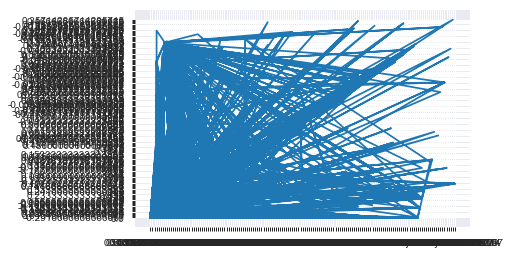

In [20]:
import matplotlib.pyplot as plt
import matplotlib
x = btcdf['subjectivity']
y = btcdf['polarity']
plt.plot(x,y)
plt.show()

In [21]:
frames = [btcdf, df]
result = pd.concat(frames)

result.to_csv('btcDataFrame.csv')


/Users/lukegruszka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
